In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pipeline import load_index_paths
from utils import get_images_percentiles

from sklearn.decomposition import PCA
# from sklearn.decomposition import SparsePCA as PCA
from sklearn.preprocessing import StandardScaler
from data_viz import save_image_grid
import torch


import utils
utils.silent = True

In [2]:
data_folder = Path("/data/ishang/FUCCI-dataset-well/")
index_file = "index_clean_no_border_rm_1000_sharp_1250.csv"
index_path = data_folder / index_file

image_paths, mask_paths, _ = load_index_paths(index_path)
percentiles_path = data_folder / "well_percentiles.npy"

eval_percentiles = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 99, 100]

In [3]:
if percentiles_path.exists():
    well_percentiles = np.load(percentiles_path)
else:
    well_percentiles = []
    for image_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Calculating well percentiles"):
        image = np.load(image_path)
        mask_path = str(mask_path) + ".npy"
        mask = np.load(mask_path)[:, None, ...]
        image = image * (mask > 0)
        values, percentiles = get_images_percentiles(image, percentiles=eval_percentiles, non_zero=True)
        assert (values > 0).all(), "Values should be positive"
        well_percentiles.append(values)

    well_percentiles = np.array(well_percentiles) # W x C x P

    np.save(data_folder / "well_percentiles.npy", well_percentiles)

In [4]:
plot_percentile_indices = [0, 1, 3, 6, 9, 12, 15, 17, 18]
plot_percentiles = np.array(eval_percentiles)[plot_percentile_indices]
print(plot_percentiles)
plot_well_percentiles = well_percentiles.transpose(1, 0, 2) # C x W x P
plot_well_percentiles = plot_well_percentiles[:, :, plot_percentile_indices]

[  0   1  10  25  50  75  90  99 100]


/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

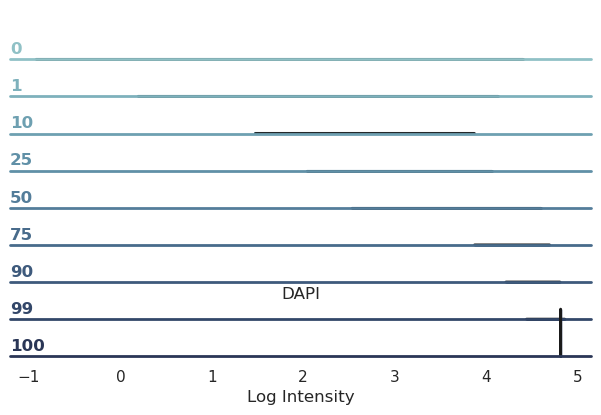

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

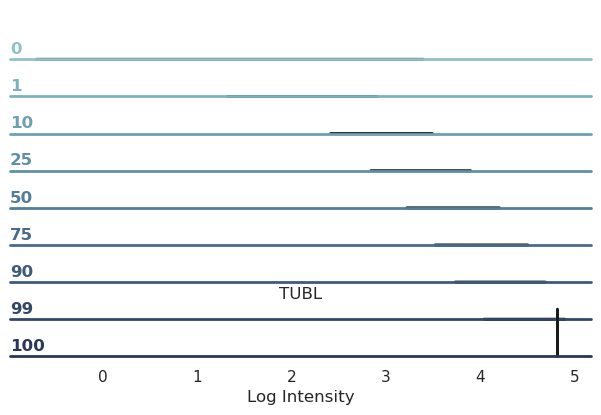

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

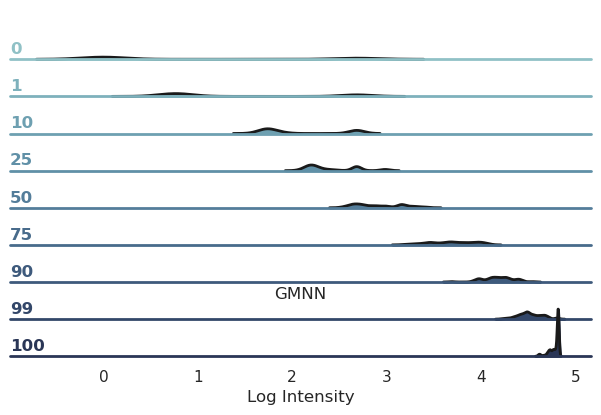

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

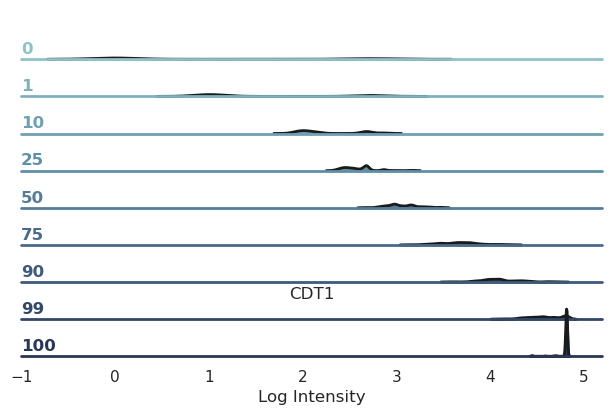

In [31]:
channel_names = ["DAPI", "TUBL", "GMNN", "CDT1"]
def channel_ridgeplots(percentile_values, log=True):
    df_percentiles = np.tile(plot_percentiles, (percentile_values.shape[1],)) # W * P
    for j, channel in enumerate(channel_names):
        plt.clf()
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        values = percentile_values[j].flatten()
        x_axis_label = "Log Intensity" if log else "Intensity"
        x_values = np.log10(values) if log else values
        df = pd.DataFrame({"Percentile": df_percentiles, x_axis_label: x_values})
        
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="Percentile", hue="Percentile", aspect=15, height=.5, palette=pal)

        # Draw the density plot and a contour around it
        g.map(sns.kdeplot, x_axis_label,
            bw_adjust=.5, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, x_axis_label, clip_on=False, color="k", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, x_axis_label)

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

        # plt.tight_layout()
        plt.title(channel)
        plt.show()
channel_ridgeplots(plot_well_percentiles)

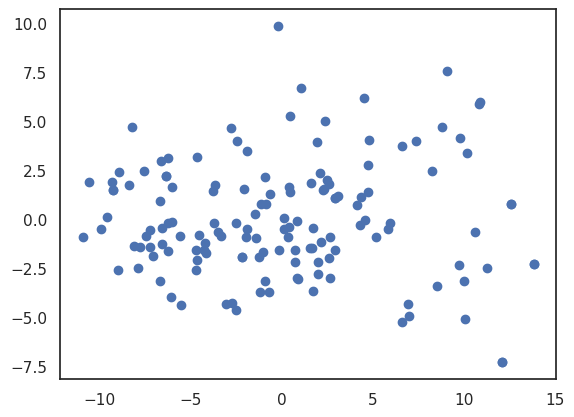

Explained variance ratio: [0.48321439 0.11253237 0.1011231  0.06244506 0.05164816 0.031172
 0.02331417 0.02222209 0.01544064 0.01365381 0.0116505  0.01046885
 0.00997657 0.00633711 0.00604223]


In [20]:
# PCA of well percentiles
def percentiles_PCA(well_percentiles, color=None):
    well_percentiles = well_percentiles.reshape(well_percentiles.shape[0], -1) # W x (C * P)
    scaler = StandardScaler()
    scaled_well_percentiles = scaler.fit_transform(well_percentiles)
    pca = PCA(n_components=15)
    well_pca = pca.fit_transform(scaled_well_percentiles)
    plt.clf()
    if color is None:
        plt.scatter(well_pca[:, 0], well_pca[:, 1])
    else:
        plt.scatter(well_pca[:, 0], well_pca[:, 1], c=color)
    plt.show()

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca, scaler

pca, scaler = percentiles_PCA(well_percentiles)
# print the top pc in terms of the original features
top_pc = pca.components_[0]
top_pc = top_pc.reshape(4, -1) # C x P

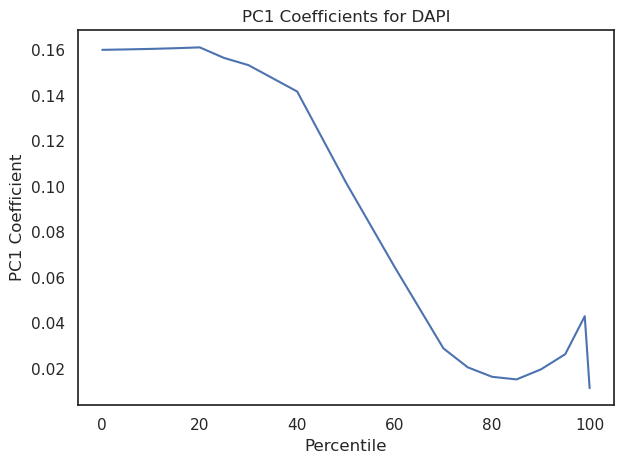

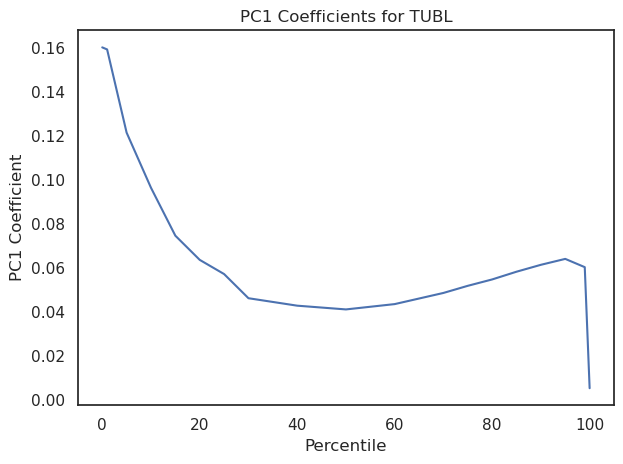

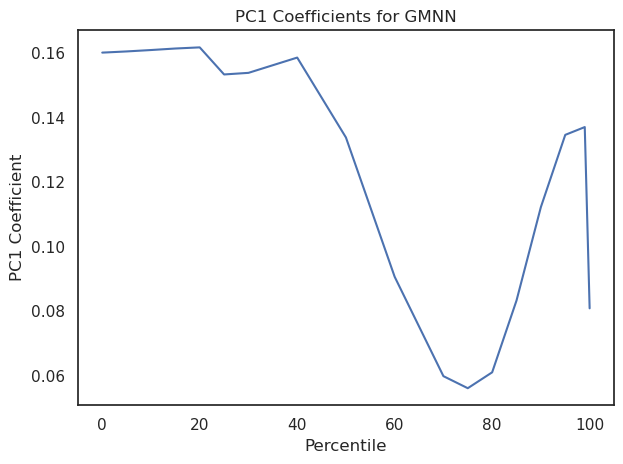

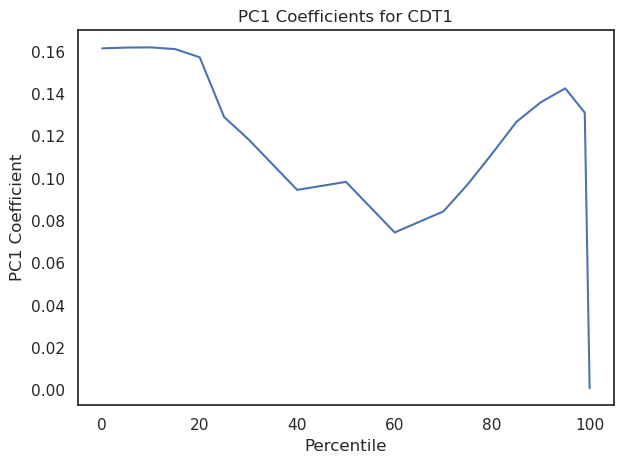

In [7]:
# plot the top pc for each channel
for j, channel in enumerate(channel_names):
    plt.clf()
    plt.plot(eval_percentiles, top_pc[j])
    plt.xlabel("Percentile")
    plt.ylabel("PC1 Coefficient")
    plt.title(f"PC1 Coefficients for {channel}")
    plt.tight_layout()
    plt.show()



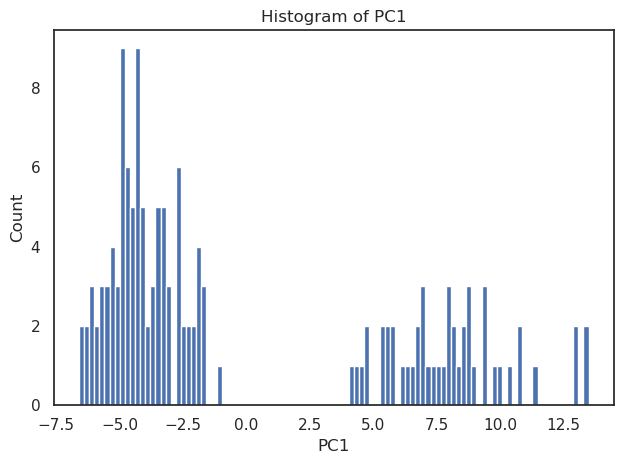

In [8]:
# plot PCA as histogram along the first PC
plt.clf()
well_pca = pca.transform(scaler.transform(well_percentiles.reshape(well_percentiles.shape[0], -1)))
plt.hist(well_pca[:, 0], bins=100)
plt.xlabel("PC1")
plt.ylabel("Count")
plt.title("Histogram of PC1")
plt.tight_layout()
plt.show()



/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


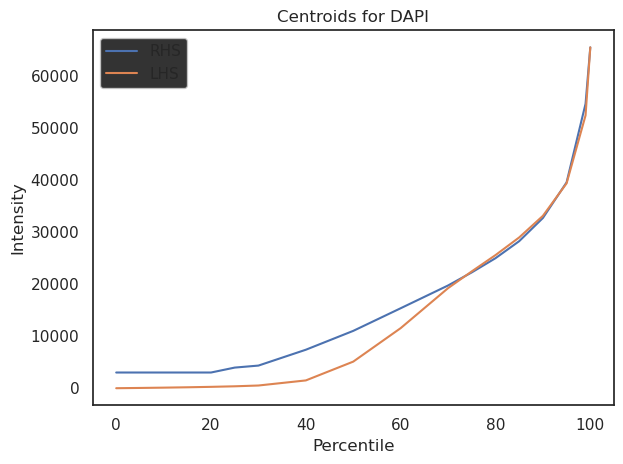

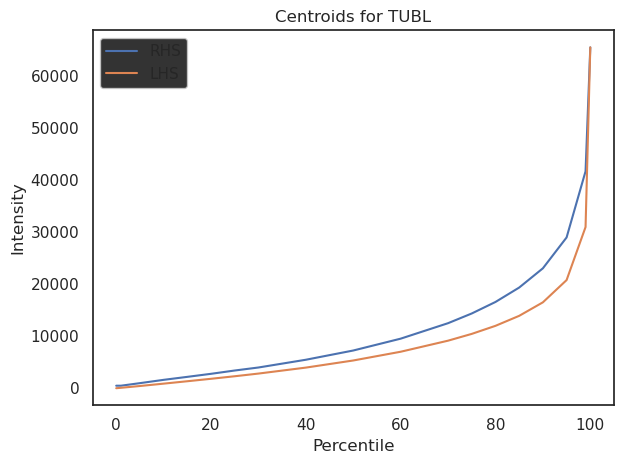

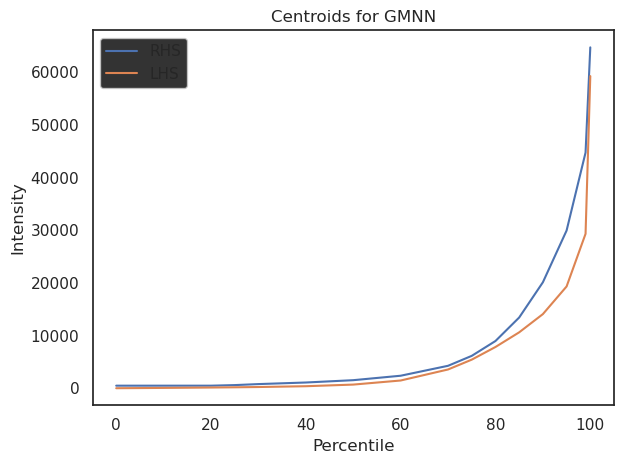

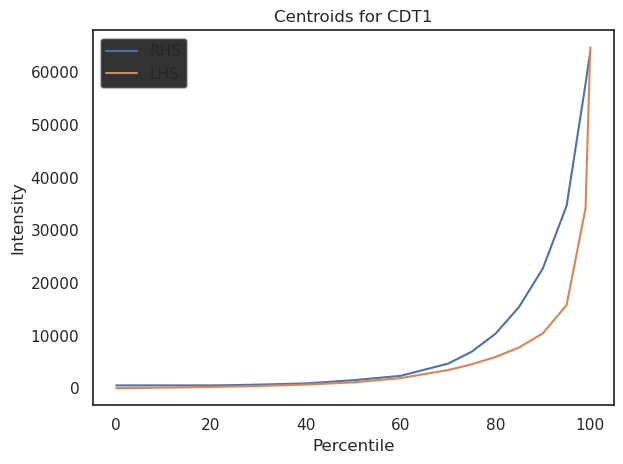

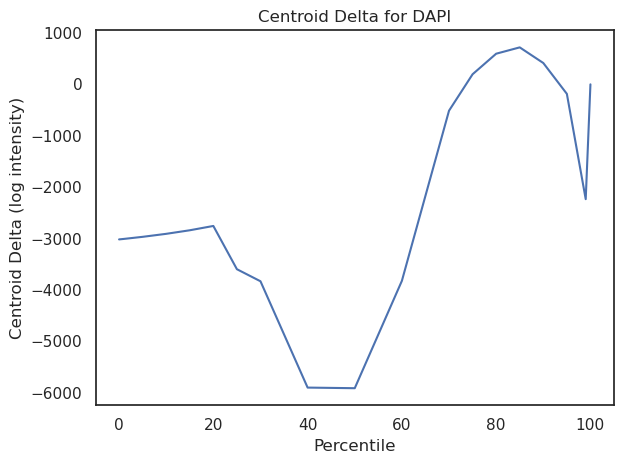

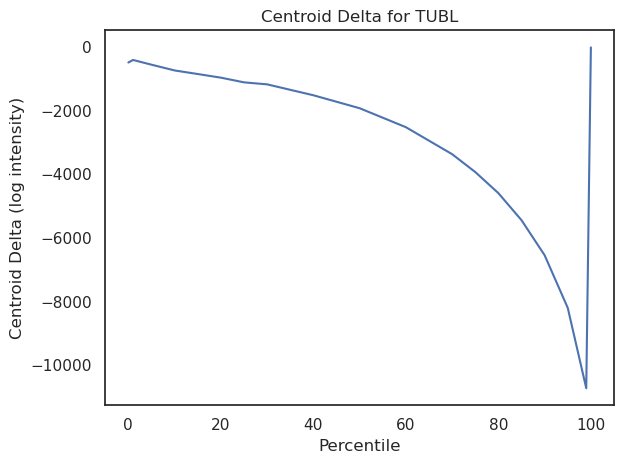

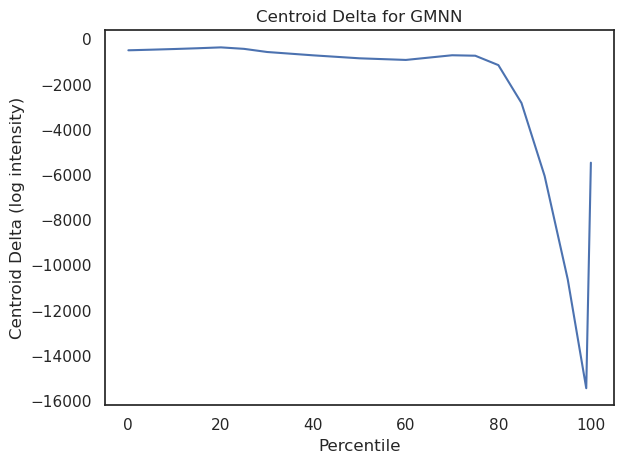

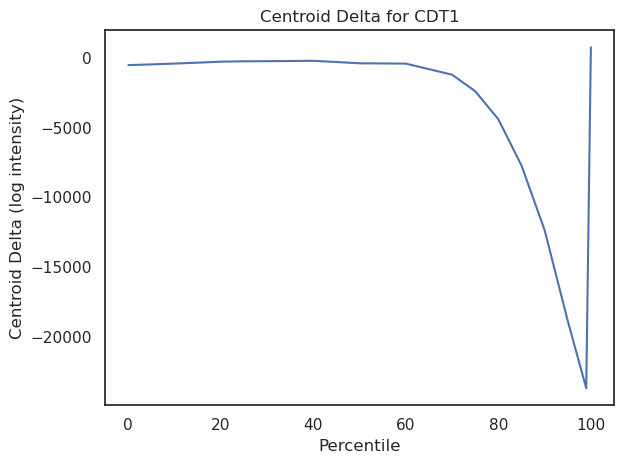

In [13]:
# fit k-means on the first two PCs
from sklearn.cluster import KMeans
def kmeans_PCA(well_pca, pca, scaler):
    kmeans = KMeans(n_clusters=2).fit(well_pca)

    # pass centroids backwards through the pca and standard scaler to get the delta in the original feature space
    RHS_centroid = kmeans.cluster_centers_[0] if kmeans.cluster_centers_[0, 0] > kmeans.cluster_centers_[1, 0] else kmeans.cluster_centers_[1]
    LHS_centroid = kmeans.cluster_centers_[0] if kmeans.cluster_centers_[0, 0] <= kmeans.cluster_centers_[1, 0] else kmeans.cluster_centers_[1]

    def centroid_to_intensity(c, pca, scaler):
        padded_vector = np.zeros((pca.n_components_,))
        padded_vector[:len(c)] = c
        c = padded_vector.reshape(1, -1)
        c = pca.inverse_transform(c)
        c = scaler.inverse_transform(c)
        c = c.reshape(4, -1) # C x P
        return c

    RHS_centroid = centroid_to_intensity(RHS_centroid, pca, scaler)
    LHS_centroid = centroid_to_intensity(LHS_centroid, pca, scaler)

    # check if the centroids are valid percentiles
    for j, channel in enumerate(channel_names):
        plt.clf()
        plt.plot(eval_percentiles, RHS_centroid[j], label="RHS")
        plt.plot(eval_percentiles, LHS_centroid[j], label="LHS")
        plt.xlabel("Percentile")
        plt.ylabel("Intensity")
        plt.title(f"Centroids for {channel}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    centroid_delta = LHS_centroid - RHS_centroid
    # print(f"Centroid delta: {centroid_delta}")

    def signed_log10(x):
        for i in range(len(x)):
            if x[i] == 0:
                x[i] = 0
            else:
                x[i] = np.sign(x[i]) * np.log10(np.abs(x[i]))
        return x

    # plot the centroid delta for each channel
    for j, channel in enumerate(channel_names):
        plt.clf()
        # plt.plot(eval_percentiles, signed_log10(centroid_delta[i]))
        plt.plot(eval_percentiles, centroid_delta[j])
        plt.xlabel("Percentile")
        plt.ylabel("Centroid Delta (log intensity)")
        plt.title(f"Centroid Delta for {channel}")
        plt.tight_layout()
        plt.show()

    return RHS_centroid, LHS_centroid, centroid_delta

RHS_centroid, LHS_centroid, centroid_delta = kmeans_PCA(well_pca, pca, scaler)

99 43


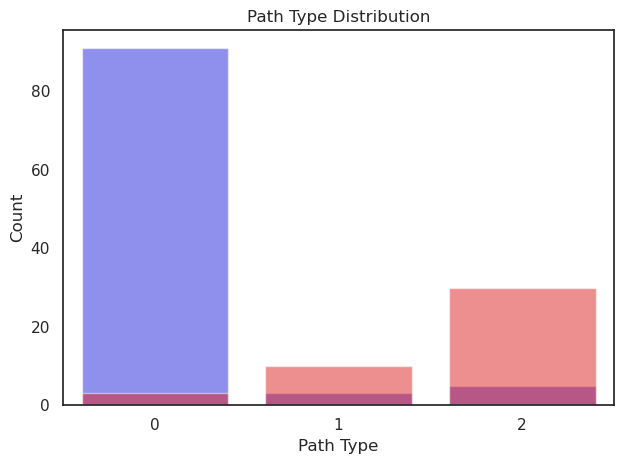

In [14]:
# sort the wells by centroid
LHC, RHC = [], []
LH_paths, RH_paths = [], []
path_types = {"chamber":0, "overview":1, "tilescan":2}
well_path_types = []
def path_to_type(path):
    for p in path_types.keys():
        if p in path:
            return path_types[p]
    return -1

for well, path in zip(well_percentiles, image_paths):
    well = well.reshape(4, -1) # C x P
    # if np.linalg.norm(well - LHS_centroid) < np.linalg.norm(well - RHS_centroid):
    if np.linalg.norm(well - LHS_centroid) < np.linalg.norm(well - RHS_centroid):
        LHC.append(well)
        LH_paths.append(path_to_type(str(path)))
    else:
        RHC.append(well)
        RH_paths.append(path_to_type(str(path)))
    well_path_types.append(path_to_type(str(path)))

print(len(LHC), len(RHC))

# plot the distribution of path types per cluster as an sns barchart
plt.clf()
sns.barplot(x=list(path_types.values()), y=[LH_paths.count(i) for i in path_types.values()], color="blue", alpha=0.5)
sns.barplot(x=list(path_types.values()), y=[RH_paths.count(i) for i in path_types.values()], color="red", alpha=0.5)
plt.xlabel("Path Type")
plt.ylabel("Count")
plt.title("Path Type Distribution")
plt.tight_layout()
plt.show()

In [11]:
# function to apply the centroid delta transform to a well
def apply_centroid_delta_RHS(well_percentiles, centroid_delta):
    clip_count = 0
    # well_percentiles is a single well here
    well_percentiles = well_percentiles.reshape(4, -1) # C x P
    assert well_percentiles.shape == centroid_delta.shape
    for i, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles)):
            clipped = False
            well_percentiles[i, p] += centroid_delta[i, p]
            if p > 1 and well_percentiles[i, p] < well_percentiles[i, p - 1]:
                well_percentiles[i, p] = well_percentiles[i, p - 1]
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {well_percentiles[i, p - 1]}")
                clipped = True
            if well_percentiles[i, p] < 0:
                well_percentiles[i, p] = 0
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to 0")
                clipped = True
            # almost all are subtractive so this shouldn't be needed
            # also why this is iterating from 0 to 100
            if well_percentiles[i, p] > np.iinfo(np.uint16).max:
                well_percentiles[i, p] = np.iinfo(np.uint16).max
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {np.iinfo(np.uint16).max}")
                clipped = True
            clip_count += int(clipped)
    return well_percentiles, clip_count

def apply_centroid_delta_LHS(well_percentiles, centroid_delta):
    clip_count = 0
    well_percentiles = well_percentiles.reshape(4, -1) # C x P
    for i, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles) - 1, -1, -1):
            clipped = False
            well_percentiles[i, p] += centroid_delta[i, p]
            if p < len(eval_percentiles) - 1 and well_percentiles[i, p] > well_percentiles[i, p + 1]:
                well_percentiles[i, p] = well_percentiles[i, p + 1]
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {well_percentiles[i, p + 1]}")
                clipped = True
            if well_percentiles[i, p] > np.iinfo(np.uint16).max:
                well_percentiles[i, p] = np.iinfo(np.uint16).max
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {np.iinfo(np.uint16).max}")
                clipped = True
            # almost all are additive so this shouldn't be needed
            # also why this is iterating from 100 to 0
            if well_percentiles[i, p] < 0:
                well_percentiles[i, p] = 0
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to 0")
                clipped = True
            clip_count += int(clipped)
    return well_percentiles, clip_count

In [15]:
transformed_well_percentiles = []
total_clipping = 0
total_transformed = 0
for cluster, well in zip(well_path_types, well_percentiles):
    # check if the well corresponds to the LHS or RHS cluster
    # only transform the ones closer to the RHS cluster
    # well_pca = pca.transform(scaler.transform(well.reshape(1, -1)))
    # dist_LHS, dist_RHS = np.sum(np.abs(well_pca[0, 0] - LHS_centroid[0])), np.sum(np.abs(well_pca[0, 0] - RHS_centroid[0]))
    # well_sq = well.reshape(4, -1)
    # dist_LHS, dist_RHS = np.linalg.norm(well_sq - LHS_centroid), np.linalg.norm(well_sq - RHS_centroid)
    # if dist_LHS > dist_RHS:
    if cluster > 0:
        transformed_well, clip_count = apply_centroid_delta_RHS(well, centroid_delta)
        # transformed_well, clip_count = apply_centroid_delta_RHS(well, centroid_delta * 0.5)
        total_clipping += clip_count
        total_transformed += 1
        transformed_well_percentiles.append(transformed_well)
    else:
        transformed_well_percentiles.append(well.reshape(4, -1))
        # transformed_well, clip_count = apply_centroid_delta_LHS(well, centroid_delta * -0.5)
        # total_clipping += clip_count
        # total_transformed += 1
        # transformed_well_percentiles.append(transformed_well)
transformed_well_percentiles = np.array(transformed_well_percentiles)
# transformed_well_percentiles = transformed_well_percentiles.transpose(1, 0, 2) # C x W x P
print(f"Total transformed: {total_transformed}")
print(f"Total clipping: {total_clipping}")
print(f"Portion Clipped: {total_clipping / (total_transformed * 4 * len(eval_percentiles))}")

# check all well percentiles are monotonically increasing
for well in transformed_well_percentiles:
    for j, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles)):
            if p > 1 and well[j, p] < well[j, p - 1]:
                print(f"well {j} channel {channel} percentile {p} is smaller than percentile {p - 1}")

plot_transformed_well_percentiles = transformed_well_percentiles[:, :, plot_percentile_indices]

Clipping DAPI at percentile 25 to 265.21201375302644
Clipping DAPI at percentile 30 to 265.21201375302644
Clipping DAPI at percentile 40 to 265.21201375302644
Clipping DAPI at percentile 50 to 265.21201375302644
Clipping GMNN at percentile 25 to 130.3304214010961
Clipping GMNN at percentile 30 to 130.3304214010961
Clipping GMNN at percentile 50 to 258.29367905376785
Clipping CDT1 at percentile 0 to 0
Clipping CDT1 at percentile 1 to 0
Clipping CDT1 at percentile 5 to 0.0
Clipping CDT1 at percentile 60 to 558.7786586785346
Clipping CDT1 at percentile 70 to 558.7786586785346
Clipping CDT1 at percentile 75 to 558.7786586785346
Clipping CDT1 at percentile 80 to 558.7786586785346
Clipping CDT1 at percentile 85 to 558.7786586785346
Clipping CDT1 at percentile 90 to 558.7786586785346
Clipping CDT1 at percentile 95 to 558.7786586785346
Clipping CDT1 at percentile 100 to 65535
Clipping DAPI at percentile 25 to 265.21201375302644
Clipping DAPI at percentile 30 to 265.21201375302644
Clipping DAPI

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

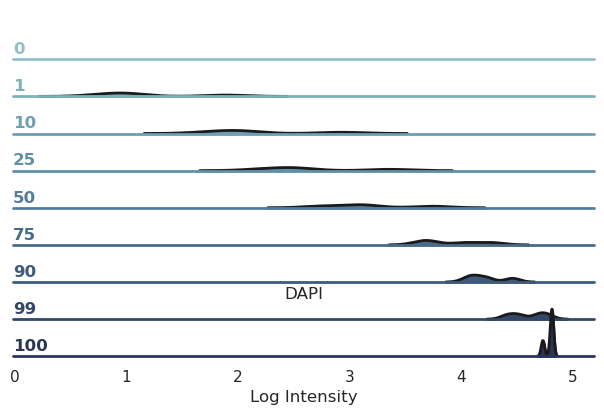

/tmp/ipykernel_623080/989995425.py:8: RuntimeWarning: divide by zero encountered in log10
  df = pd.DataFrame({"Percentile": df_percentiles, "Log Intensity": np.log10(values)})
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

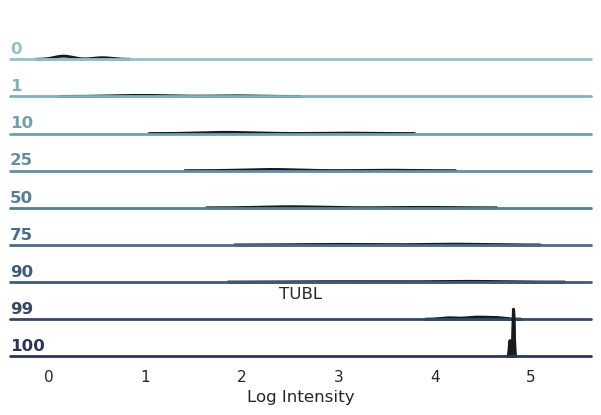

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

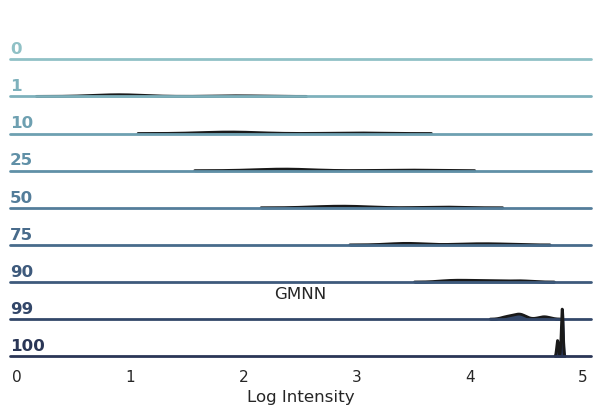

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

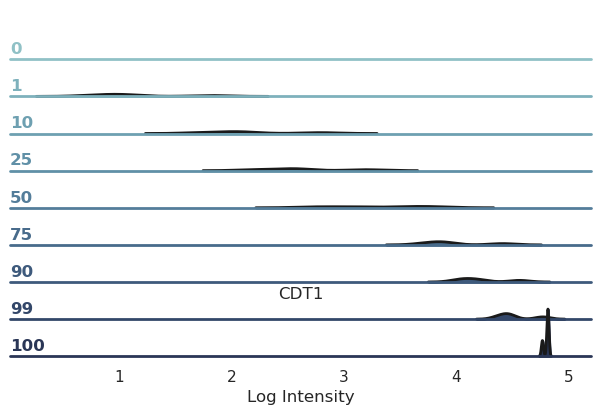

In [16]:
# plot the transformed well percentiles as ridge plots again
channel_ridgeplots(plot_transformed_well_percentiles)

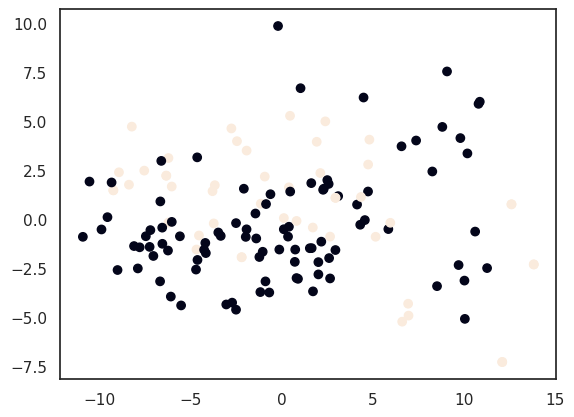

Explained variance ratio: [0.48321439 0.11253237 0.1011231  0.06244506 0.05164816 0.031172
 0.02331417 0.02222209 0.01544064 0.01365381 0.0116505  0.01046885
 0.00997657 0.00633711 0.00604223]


(PCA(n_components=15), StandardScaler())

In [22]:
# Do PCA on the transformed data and see if it still segregates
percentiles_PCA(transformed_well_percentiles, color=(np.array(well_path_types) > 0).astype(int))

In [27]:
# rescale the transformed well percentiles to [0, 1] ranges per channel
normalized_well_percentiles = np.copy(transformed_well_percentiles)
print(normalized_well_percentiles.shape)
for i in range(normalized_well_percentiles.shape[0]):
    for j in range(normalized_well_percentiles.shape[1]):
        well_min = normalized_well_percentiles[i][j].min()
        well_max = normalized_well_percentiles[i][j].max()
        if well_min == well_max:
            print(f"well {i} channel {channel_names[j]} has min == max: {well_min}")
            print(normalized_well_percentiles[i][j])
        normalized_well_percentiles[i][j] = (normalized_well_percentiles[i][j] - well_min) / (well_max - well_min)

print(normalized_well_percentiles.min(), normalized_well_percentiles.max())

(142, 4, 19)
0.0 1.0


/tmp/ipykernel_623080/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

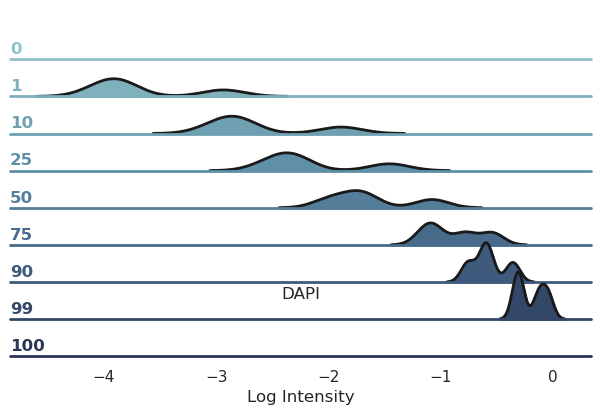

/tmp/ipykernel_623080/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

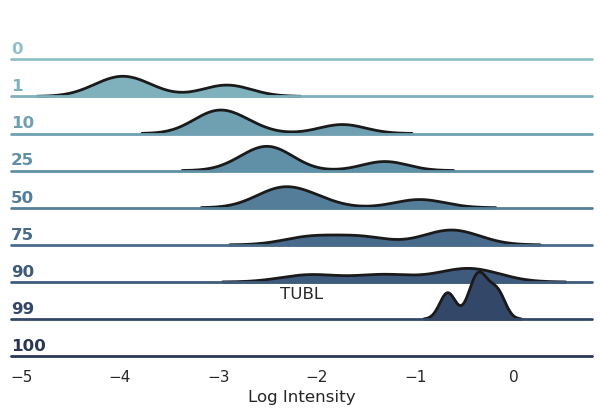

/tmp/ipykernel_623080/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

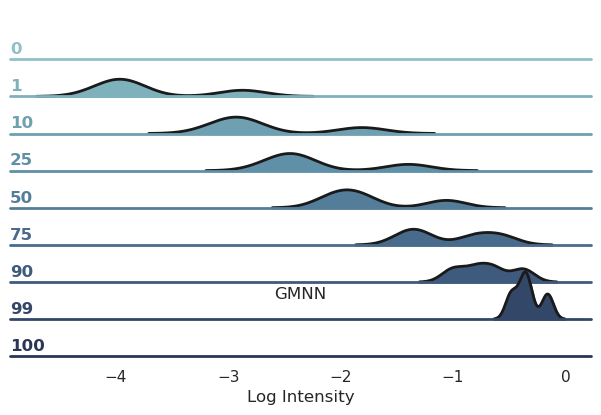

/tmp/ipykernel_623080/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

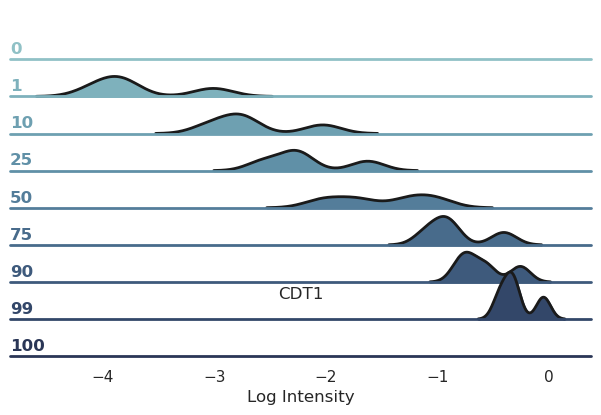

In [33]:
# plot the transformed well percentiles as ridge plots again
plot_normalized_well_percentiles = normalized_well_percentiles[:, :, plot_percentile_indices]
channel_ridgeplots(plot_normalized_well_percentiles)

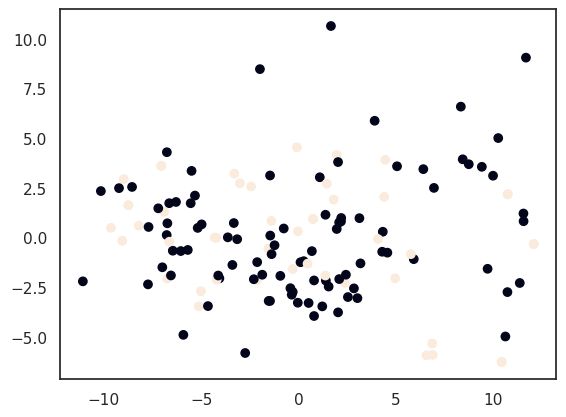

Explained variance ratio: [0.50396129 0.12975845 0.10003586 0.07017709 0.03945932 0.034956
 0.0226979  0.01690133 0.01436871 0.01088922 0.00770853 0.00670624
 0.0055364  0.00509991 0.00451438]


(PCA(n_components=15), StandardScaler())

In [34]:
# do a PCA on the normalized well percentiles
percentiles_PCA(normalized_well_percentiles, color=(np.array(well_path_types) > 0).astype(int))

In [42]:
def well_normalization_map(original_perc, transformed_perc):
    def normalize(well_images):
        # well images are B x C x H x W
        for c in range(original_perc.shape[0]):
            # bucket the image pixels into the percentile ranges
            print(well_images.shape)
            print(original_perc.shape)
            well_images_perc = np.digitize(well_images[:, c], original_perc[c], right=False)

            # then normalize the image by the percentile range using a linear extrapolation within the bucket
            def normalize_pixel(x):
                perc_below = original_perc[c, x] if x < len(original_perc[c]) else original_perc[c, -1]
                perc_above = original_perc[c, x + 1] if x < len(original_perc[c]) - 1 else original_perc[c, -1]
                transformed_perc_below = transformed_perc[c, x] if x < len(transformed_perc[c]) else transformed_perc[c, -1]
                transformed_perc_above = transformed_perc[c, x + 1] if x < len(transformed_perc[c]) - 1 else transformed_perc[c, -1]
                if perc_above == perc_below:
                    assert transformed_perc_above == transformed_perc_below
                    return transformed_perc_below
                bucket_pos = (x - perc_below) / (perc_above - perc_below)
                transformed_value = transformed_perc_below + bucket_pos * (transformed_perc_above - transformed_perc_below)
                return transformed_value
            
            normalize_pixel = np.vectorize(normalize_pixel)

            well_images[:, c] = normalize_pixel(well_images_perc)
        return well_images
    return normalize


for i, (image_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), total=len(image_paths), desc="Calculating well percentiles"):
    normalization_function = well_normalization_map(well_percentiles[i], transformed_well_percentiles[i])
    images = np.load(image_path)
    masks_path = str(mask_path) + ".npy"
    masks = np.load(masks_path)[:, None, ...]
    images = images * (masks > 0)
    normalized_images = normalization_function(images)
    for orig, norm in zip(images, normalized_images):
        # normalize each channel of orig to [0, 1]
        for c in range(orig.shape[0]):
            orig[c] = (orig[c] - orig[c].min()) / (orig[c].max() - orig[c].min())
        orig, norm = torch.from_numpy(orig), torch.from_numpy(norm)
        save_image_grid(torch.concatenate([orig, norm]), "test_image.png", nrow=orig.shape[0], cmaps=None)
    break

Calculating well percentiles:   0%|          | 0/142 [00:00<?, ?it/s]

(10, 4, 2048, 2048)
(4, 19)
